# Bi-encoder training

In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import MatchingDataset
from torch.utils.data import random_split

from tqdm import tqdm
import numpy as np
import random

In [2]:
# import tarfile
# import os

# def extract_tar_gz(tar_gz_path, extract_path="."):
#     if tarfile.is_tarfile(tar_gz_path):
#         with tarfile.open(tar_gz_path, "r:gz") as tar:
#             tar.extractall(path=extract_path)
#         print(f"Extracted {tar_gz_path} to {extract_path}")
#     else:
#         print(f"{tar_gz_path} is not a valid tar.gz file")

# extract_tar_gz("brandenburg_gate.tar.gz", extract_path="./datasets")


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
class BiEncoder(nn.Module):
    def __init__(self, input_dim: int = 2 + 32, embed_dim: int = 128):
        super(BiEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim)
        )

    def forward(self, x):
        return self.encoder(x)

In [5]:
def contrastive_loss(anchor, positive, negative, margin=1.0):
    pos_dist = torch.norm(anchor - positive, dim=1)
    neg_dist = torch.norm(anchor - negative, dim=1)
    loss = torch.clamp(margin + pos_dist - neg_dist, min=0.0)
    return loss.mean()

In [6]:
datasets_path = ["brandenburg_gate", "buckingham_palace", "sacre_coeur", "st_pauls_cathedral", "palace_of_westminster"]
dataset = MatchingDataset(
    datasets=datasets_path,
    detector_type="ORB",
    n_keypoints=512,
    max_pairs_per_dataset=10000
)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

Extracting brandenburg_gate data...


Processing brandenburg_gate image pairs: 100%|██████████| 10000/10000 [15:59<00:00, 10.42it/s]


Extracting buckingham_palace data...


Processing buckingham_palace image pairs: 100%|██████████| 10000/10000 [16:42<00:00,  9.97it/s]


Extracting sacre_coeur data...


Processing sacre_coeur image pairs: 100%|██████████| 10000/10000 [16:42<00:00,  9.97it/s]


Extracting st_pauls_cathedral data...


Processing st_pauls_cathedral image pairs: 100%|██████████| 10000/10000 [16:03<00:00, 10.38it/s]


Extracting palace_of_westminster data...


Processing palace_of_westminster image pairs: 100%|██████████| 10000/10000 [15:28<00:00, 10.77it/s]

Samples with padding: 619/50000


In [14]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [21]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
encoder1 = BiEncoder(input_dim=2 + 32).to(device)
encoder2 = BiEncoder(input_dim=2 + 32).to(device)

params = list(encoder1.parameters()) + list(encoder2.parameters())
optimizer = optim.Adam(params, lr=1e-4)

In [24]:
def evaluate_model(encoder1: nn.Module, encoder2: nn.Module, dataloader: DataLoader, device: str = "cuda", k: int = 5):
    encoder1.eval()
    encoder2.eval()
    
    total_matches = 0
    correct_matches = 0
    recall_correct = 0
    total_with_labels = 0
    loss_sum = 0.0
    num_batches = 0

    with torch.no_grad():
        for data_batch, labels_batch in tqdm(dataloader):
            data_batch = data_batch.to(device).float()
            labels_batch = labels_batch.to(device).long()

            keypts1 = data_batch[:, :, :2]
            desc1 = data_batch[:, :, 2:34]
            keypts2 = data_batch[:, :, 34:36]
            desc2 = data_batch[:, :, 36:]

            input1 = torch.cat([keypts1, desc1], dim=2)
            input2 = torch.cat([keypts2, desc2], dim=2)

            B, N, _ = input1.shape
            anchor = encoder1(input1.view(B*N, -1))
            positive = encoder2(input2.view(B*N, -1))

            shuffled_idx = torch.randperm(B*N)
            negative = positive[shuffled_idx]

            loss = contrastive_loss(anchor, positive, negative)
            loss_sum += loss.item()
            num_batches += 1

            anchor = anchor.view(B, N, -1)
            positive = positive.view(B, N, -1)
            for b in range(B):
                sim = torch.matmul(anchor[b], positive[b].T)  # [N x N]
                pred_matches = torch.argmax(sim, dim=1)
                true_matches = labels_batch[b]

                # Matching accuracy
                valid_mask = true_matches != -1
                correct_matches += (pred_matches[valid_mask] == true_matches[valid_mask]).sum().item()
                total_matches += valid_mask.sum().item()

                # Recall@k
                topk = torch.topk(sim, k=k, dim=1).indices
                for i in range(N):
                    if true_matches[i] != -1:
                        total_with_labels += 1
                        if true_matches[i] in topk[i]:
                            recall_correct += 1

    accuracy = correct_matches / total_matches if total_matches > 0 else 0.0
    recall = recall_correct / total_with_labels if total_with_labels > 0 else 0.0
    avg_loss = loss_sum / len(dataloader) if num_batches > 0 else 0.0

    return {
        "accuracy": accuracy,
        f"recall@{k}": recall,
        "loss": avg_loss
    }


In [25]:
loss_history = []
train_loss_history = []
val_loss_history = []
val_acc_history = []
val_rec_history = []

In [26]:
epochs = 100
for epoch in range(epochs):
    encoder1.train()
    encoder2.train()
    running_loss = 0.0

    for data_batch, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        data_batch = data_batch.to(device).float()
        labels_batch = labels_batch.to(device).long() 

        keypts1 = data_batch[:, :, :2] 
        desc1 = data_batch[:, :, 2:34]
        keypts2 = data_batch[:, :, 34:36]
        desc2 = data_batch[:, :, 36:] 

        input1 = torch.cat([keypts1, desc1], dim=2)
        input2 = torch.cat([keypts2, desc2], dim=2) 

        B, N, _ = input1.shape
        anchor = encoder1(input1.view(B*N, -1))
        positive = encoder2(input2.view(B*N, -1))

        shuffled_idx = torch.randperm(B*N)
        negative = positive[shuffled_idx]

        loss = contrastive_loss(anchor, positive, negative)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history.append(loss.item())
    running_loss /= len(train_loader)
    train_loss_history.append(running_loss)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        val_res = evaluate_model(encoder1, encoder2, test_loader)
        val_loss, val_acc, val_recall = val_res["loss"], val_res["accuracy"], val_res["recall@5"]
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_rec_history.append(val_recall)
        print(f"Validation. Loss: {val_loss}, Accuracy: {val_acc}, Recall@5: {val_recall}")

torch.save({
    'encoder1_state_dict': encoder1.state_dict(),
    'encoder2_state_dict': encoder2.state_dict()
}, 'bi_encoder.pth')


Epoch 1/100: 100%|██████████| 176/176 [00:13<00:00, 13.48it/s]


Epoch 1, Loss: 4.1864


Epoch 2/100: 100%|██████████| 176/176 [00:12<00:00, 13.85it/s]


Epoch 2, Loss: 1.3955


Epoch 3/100: 100%|██████████| 176/176 [00:12<00:00, 14.22it/s]


Epoch 3, Loss: 1.1040


Epoch 4/100: 100%|██████████| 176/176 [00:12<00:00, 14.06it/s]


Epoch 4, Loss: 1.0346


Epoch 5/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 5, Loss: 1.0081


100%|██████████| 5000/5000 [04:40<00:00, 17.80it/s]


Validation. Loss: 1.0373305847883225, Accuracy: 0.002597147029949063, Recall@5: 0.01275590562744561


Epoch 6/100: 100%|██████████| 176/176 [00:12<00:00, 14.06it/s]


Epoch 6, Loss: 0.9948


Epoch 7/100: 100%|██████████| 176/176 [00:12<00:00, 13.83it/s]


Epoch 7, Loss: 0.9857


Epoch 8/100: 100%|██████████| 176/176 [00:12<00:00, 14.07it/s]


Epoch 8, Loss: 0.9801


Epoch 9/100: 100%|██████████| 176/176 [00:12<00:00, 14.15it/s]


Epoch 9, Loss: 0.9749


Epoch 10/100: 100%|██████████| 176/176 [00:12<00:00, 14.00it/s]


Epoch 10, Loss: 0.9714


100%|██████████| 5000/5000 [04:30<00:00, 18.45it/s]


Validation. Loss: 1.0224828149795533, Accuracy: 0.0035708018113209763, Recall@5: 0.01712707222888377


Epoch 11/100: 100%|██████████| 176/176 [00:12<00:00, 13.55it/s]


Epoch 11, Loss: 0.9672


Epoch 12/100: 100%|██████████| 176/176 [00:12<00:00, 13.64it/s]


Epoch 12, Loss: 0.9640


Epoch 13/100: 100%|██████████| 176/176 [00:12<00:00, 13.70it/s]


Epoch 13, Loss: 0.9607


Epoch 14/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 14, Loss: 0.9593


Epoch 15/100: 100%|██████████| 176/176 [00:12<00:00, 13.67it/s]


Epoch 15, Loss: 0.9557


100%|██████████| 5000/5000 [03:24<00:00, 24.45it/s]


Validation. Loss: 1.0195804608821868, Accuracy: 0.003966578528635804, Recall@5: 0.019075116071251556


Epoch 16/100: 100%|██████████| 176/176 [00:12<00:00, 13.68it/s]


Epoch 16, Loss: 0.9534


Epoch 17/100: 100%|██████████| 176/176 [00:12<00:00, 13.59it/s]


Epoch 17, Loss: 0.9511


Epoch 18/100: 100%|██████████| 176/176 [00:12<00:00, 13.66it/s]


Epoch 18, Loss: 0.9492


Epoch 19/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 19, Loss: 0.9464


Epoch 20/100: 100%|██████████| 176/176 [00:12<00:00, 13.60it/s]


Epoch 20, Loss: 0.9445


100%|██████████| 5000/5000 [03:24<00:00, 24.42it/s]


Validation. Loss: 1.0185861696720124, Accuracy: 0.004337389738735967, Recall@5: 0.020683922727349494


Epoch 21/100: 100%|██████████| 176/176 [00:12<00:00, 13.58it/s]


Epoch 21, Loss: 0.9432


Epoch 22/100: 100%|██████████| 176/176 [00:12<00:00, 13.66it/s]


Epoch 22, Loss: 0.9409


Epoch 23/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 23, Loss: 0.9390


Epoch 24/100: 100%|██████████| 176/176 [00:12<00:00, 13.63it/s]


Epoch 24, Loss: 0.9371


Epoch 25/100: 100%|██████████| 176/176 [00:12<00:00, 13.58it/s]


Epoch 25, Loss: 0.9352


100%|██████████| 5000/5000 [03:24<00:00, 24.46it/s]


Validation. Loss: 1.0176271408319473, Accuracy: 0.00419787661018343, Recall@5: 0.019656665533428447


Epoch 26/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 26, Loss: 0.9339


Epoch 27/100: 100%|██████████| 176/176 [00:12<00:00, 13.69it/s]


Epoch 27, Loss: 0.9333


Epoch 28/100: 100%|██████████| 176/176 [00:12<00:00, 14.12it/s]


Epoch 28, Loss: 0.9308


Epoch 29/100: 100%|██████████| 176/176 [00:13<00:00, 13.25it/s]


Epoch 29, Loss: 0.9296


Epoch 30/100: 100%|██████████| 176/176 [00:13<00:00, 13.38it/s]


Epoch 30, Loss: 0.9289


100%|██████████| 5000/5000 [04:31<00:00, 18.43it/s]


Validation. Loss: 1.0198467214822768, Accuracy: 0.004468825791424936, Recall@5: 0.02065969149975879


Epoch 31/100: 100%|██████████| 176/176 [00:12<00:00, 14.06it/s]


Epoch 31, Loss: 0.9269


Epoch 32/100: 100%|██████████| 176/176 [00:12<00:00, 14.15it/s]


Epoch 32, Loss: 0.9254


Epoch 33/100: 100%|██████████| 176/176 [00:12<00:00, 14.29it/s]


Epoch 33, Loss: 0.9246


Epoch 34/100: 100%|██████████| 176/176 [00:13<00:00, 13.52it/s]


Epoch 34, Loss: 0.9240


Epoch 35/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 35, Loss: 0.9219


100%|██████████| 5000/5000 [03:24<00:00, 24.47it/s]


Validation. Loss: 1.017027689766884, Accuracy: 0.004854322594004313, Recall@5: 0.022659869195427788


Epoch 36/100: 100%|██████████| 176/176 [00:13<00:00, 13.52it/s]


Epoch 36, Loss: 0.9203


Epoch 37/100: 100%|██████████| 176/176 [00:12<00:00, 13.60it/s]


Epoch 37, Loss: 0.9197


Epoch 38/100: 100%|██████████| 176/176 [00:12<00:00, 13.56it/s]


Epoch 38, Loss: 0.9186


Epoch 39/100: 100%|██████████| 176/176 [00:12<00:00, 13.60it/s]


Epoch 39, Loss: 0.9183


Epoch 40/100: 100%|██████████| 176/176 [00:13<00:00, 13.46it/s]


Epoch 40, Loss: 0.9174


100%|██████████| 5000/5000 [03:24<00:00, 24.46it/s]


Validation. Loss: 1.0159966759204864, Accuracy: 0.004772083276120713, Recall@5: 0.022615078138366183


Epoch 41/100: 100%|██████████| 176/176 [00:13<00:00, 13.51it/s]


Epoch 41, Loss: 0.9157


Epoch 42/100: 100%|██████████| 176/176 [00:12<00:00, 13.60it/s]


Epoch 42, Loss: 0.9155


Epoch 43/100: 100%|██████████| 176/176 [00:12<00:00, 13.66it/s]


Epoch 43, Loss: 0.9139


Epoch 44/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 44, Loss: 0.9129


Epoch 45/100: 100%|██████████| 176/176 [00:12<00:00, 13.58it/s]


Epoch 45, Loss: 0.9115


100%|██████████| 5000/5000 [03:24<00:00, 24.44it/s]


Validation. Loss: 1.016840341949463, Accuracy: 0.004308018553777538, Recall@5: 0.020417379223851752


Epoch 46/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 46, Loss: 0.9107


Epoch 47/100: 100%|██████████| 176/176 [00:12<00:00, 13.66it/s]


Epoch 47, Loss: 0.9102


Epoch 48/100: 100%|██████████| 176/176 [00:12<00:00, 13.60it/s]


Epoch 48, Loss: 0.9095


Epoch 49/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 49, Loss: 0.9081


Epoch 50/100: 100%|██████████| 176/176 [00:12<00:00, 13.63it/s]


Epoch 50, Loss: 0.9078


100%|██████████| 5000/5000 [03:25<00:00, 24.38it/s]


Validation. Loss: 1.0195759762048722, Accuracy: 0.004234590591381466, Recall@5: 0.020122198815019542


Epoch 51/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 51, Loss: 0.9081


Epoch 52/100: 100%|██████████| 176/176 [00:12<00:00, 13.60it/s]


Epoch 52, Loss: 0.9057


Epoch 53/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 53, Loss: 0.9054


Epoch 54/100: 100%|██████████| 176/176 [00:12<00:00, 13.56it/s]


Epoch 54, Loss: 0.9042


Epoch 55/100: 100%|██████████| 176/176 [00:13<00:00, 13.53it/s]


Epoch 55, Loss: 0.9033


100%|██████████| 5000/5000 [03:25<00:00, 24.36it/s]


Validation. Loss: 1.0163916028738023, Accuracy: 0.004457077317441565, Recall@5: 0.021158267364428118


Epoch 56/100: 100%|██████████| 176/176 [00:12<00:00, 13.61it/s]


Epoch 56, Loss: 0.9040


Epoch 57/100: 100%|██████████| 176/176 [00:12<00:00, 13.59it/s]


Epoch 57, Loss: 0.9025


Epoch 58/100: 100%|██████████| 176/176 [00:12<00:00, 13.59it/s]


Epoch 58, Loss: 0.9012


Epoch 59/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 59, Loss: 0.9007


Epoch 60/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 60, Loss: 0.8999


100%|██████████| 5000/5000 [03:25<00:00, 24.34it/s]


Validation. Loss: 1.0153988785505295, Accuracy: 0.004631101588320255, Recall@5: 0.022022514481829885


Epoch 61/100: 100%|██████████| 176/176 [00:13<00:00, 13.49it/s]


Epoch 61, Loss: 0.8993


Epoch 62/100: 100%|██████████| 176/176 [00:12<00:00, 13.55it/s]


Epoch 62, Loss: 0.9001


Epoch 63/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 63, Loss: 0.8985


Epoch 64/100: 100%|██████████| 176/176 [00:12<00:00, 13.55it/s]


Epoch 64, Loss: 0.8976


Epoch 65/100: 100%|██████████| 176/176 [00:12<00:00, 13.61it/s]


Epoch 65, Loss: 0.8970


100%|██████████| 5000/5000 [03:24<00:00, 24.42it/s]


Validation. Loss: 1.0165272593975068, Accuracy: 0.004621555953208766, Recall@5: 0.021816181907496922


Epoch 66/100: 100%|██████████| 176/176 [00:12<00:00, 13.63it/s]


Epoch 66, Loss: 0.8966


Epoch 67/100: 100%|██████████| 176/176 [00:13<00:00, 13.52it/s]


Epoch 67, Loss: 0.8959


Epoch 68/100: 100%|██████████| 176/176 [00:13<00:00, 13.54it/s]


Epoch 68, Loss: 0.8958


Epoch 69/100: 100%|██████████| 176/176 [00:12<00:00, 13.59it/s]


Epoch 69, Loss: 0.8950


Epoch 70/100: 100%|██████████| 176/176 [00:13<00:00, 13.54it/s]


Epoch 70, Loss: 0.8943


100%|██████████| 5000/5000 [03:24<00:00, 24.43it/s]


Validation. Loss: 1.0155367583274841, Accuracy: 0.004584841972010729, Recall@5: 0.021507050185809458


Epoch 71/100: 100%|██████████| 176/176 [00:12<00:00, 13.59it/s]


Epoch 71, Loss: 0.8942


Epoch 72/100: 100%|██████████| 176/176 [00:12<00:00, 13.59it/s]


Epoch 72, Loss: 0.8932


Epoch 73/100: 100%|██████████| 176/176 [00:12<00:00, 13.58it/s]


Epoch 73, Loss: 0.8929


Epoch 74/100: 100%|██████████| 176/176 [00:12<00:00, 13.56it/s]


Epoch 74, Loss: 0.8923


Epoch 75/100: 100%|██████████| 176/176 [00:13<00:00, 13.49it/s]


Epoch 75, Loss: 0.8924


100%|██████████| 5000/5000 [03:25<00:00, 24.32it/s]


Validation. Loss: 1.0162696283340453, Accuracy: 0.0046355072660640186, Recall@5: 0.021636283399626546


Epoch 76/100: 100%|██████████| 176/176 [00:13<00:00, 13.53it/s]


Epoch 76, Loss: 0.8912


Epoch 77/100: 100%|██████████| 176/176 [00:12<00:00, 13.58it/s]


Epoch 77, Loss: 0.8911


Epoch 78/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 78, Loss: 0.8903


Epoch 79/100: 100%|██████████| 176/176 [00:13<00:00, 13.47it/s]


Epoch 79, Loss: 0.8900


Epoch 80/100: 100%|██████████| 176/176 [00:13<00:00, 13.53it/s]


Epoch 80, Loss: 0.8895


100%|██████████| 5000/5000 [03:25<00:00, 24.35it/s]


Validation. Loss: 1.016359057545662, Accuracy: 0.00450407121337505, Recall@5: 0.021308060407716104


Epoch 81/100: 100%|██████████| 176/176 [00:13<00:00, 13.44it/s]


Epoch 81, Loss: 0.8889


Epoch 82/100: 100%|██████████| 176/176 [00:13<00:00, 13.52it/s]


Epoch 82, Loss: 0.8888


Epoch 83/100: 100%|██████████| 176/176 [00:12<00:00, 13.57it/s]


Epoch 83, Loss: 0.8882


Epoch 84/100: 100%|██████████| 176/176 [00:12<00:00, 13.61it/s]


Epoch 84, Loss: 0.8886


Epoch 85/100: 100%|██████████| 176/176 [00:13<00:00, 13.46it/s]


Epoch 85, Loss: 0.8873


100%|██████████| 5000/5000 [03:25<00:00, 24.36it/s]


Validation. Loss: 1.0158328464508057, Accuracy: 0.004545190872316851, Recall@5: 0.021605443655420196


Epoch 86/100: 100%|██████████| 176/176 [00:13<00:00, 13.53it/s]


Epoch 86, Loss: 0.8867


Epoch 87/100: 100%|██████████| 176/176 [00:12<00:00, 13.62it/s]


Epoch 87, Loss: 0.8862


Epoch 88/100: 100%|██████████| 176/176 [00:12<00:00, 13.54it/s]


Epoch 88, Loss: 0.8861


Epoch 89/100: 100%|██████████| 176/176 [00:13<00:00, 13.47it/s]


Epoch 89, Loss: 0.8861


Epoch 90/100: 100%|██████████| 176/176 [00:13<00:00, 13.53it/s]


Epoch 90, Loss: 0.8858


100%|██████████| 5000/5000 [04:27<00:00, 18.72it/s]


Validation. Loss: 1.0153790457487106, Accuracy: 0.0043821807957975705, Recall@5: 0.02091448652927316


Epoch 91/100: 100%|██████████| 176/176 [00:12<00:00, 14.06it/s]


Epoch 91, Loss: 0.8850


Epoch 92/100: 100%|██████████| 176/176 [00:12<00:00, 14.15it/s]


Epoch 92, Loss: 0.8848


Epoch 93/100: 100%|██████████| 176/176 [00:12<00:00, 14.06it/s]


Epoch 93, Loss: 0.8850


Epoch 94/100: 100%|██████████| 176/176 [00:12<00:00, 14.08it/s]


Epoch 94, Loss: 0.8842


Epoch 95/100: 100%|██████████| 176/176 [00:12<00:00, 14.10it/s]


Epoch 95, Loss: 0.8834


100%|██████████| 5000/5000 [04:26<00:00, 18.74it/s]


Validation. Loss: 1.0168214607954025, Accuracy: 0.004563547862915868, Recall@5: 0.021556981200238787


Epoch 96/100: 100%|██████████| 176/176 [00:12<00:00, 14.09it/s]


Epoch 96, Loss: 0.8844


Epoch 97/100: 100%|██████████| 176/176 [00:12<00:00, 14.14it/s]


Epoch 97, Loss: 0.8830


Epoch 98/100: 100%|██████████| 176/176 [00:12<00:00, 14.15it/s]


Epoch 98, Loss: 0.8834


Epoch 99/100: 100%|██████████| 176/176 [00:12<00:00, 14.08it/s]


Epoch 99, Loss: 0.8821


Epoch 100/100: 100%|██████████| 176/176 [00:12<00:00, 13.97it/s]


Epoch 100, Loss: 0.8827


100%|██████████| 5000/5000 [03:55<00:00, 21.19it/s]

Validation. Loss: 1.0170709259033204, Accuracy: 0.0045334423983334786, Recall@5: 0.02111053918887067


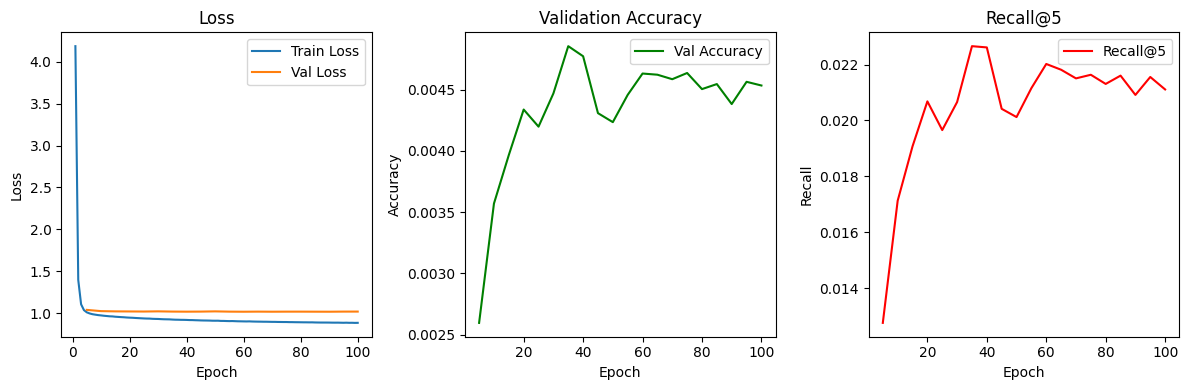

In [27]:
train_epochs = list(range(1, epochs + 1))
val_epochs = list(range(5, epochs + 1, 5))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_epochs, train_loss_history, label='Train Loss')
plt.plot(val_epochs, val_loss_history, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_epochs, val_acc_history, label='Val Accuracy', color='g')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_epochs, val_rec_history, label=f'Recall@{5}', color='r')
plt.title(f"Recall@{5}")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
encoder1 = BiEncoder(input_dim=2 + 32).to(device)
encoder2 = BiEncoder(input_dim=2 + 32).to(device)

checkpoint = torch.load("bi_encoder.pth", map_location=device)
encoder1.load_state_dict(checkpoint['encoder1_state_dict'])
encoder2.load_state_dict(checkpoint['encoder2_state_dict'])

encoder1.eval()
encoder2.eval()

BiEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=34, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [29]:
from dataset import detect_keypoints_and_descriptors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img1_path = "./brandenburg_gate/dense/images/00289298_7642283248.jpg"
img2_path = "./brandenburg_gate/dense/images/00315862_6836283050.jpg"

# Read image files as numpy arrays
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Detect keypoints and descriptors
data1 = detect_keypoints_and_descriptors(img1, detector_type="ORB", n_features=512)
data2 = detect_keypoints_and_descriptors(img2, detector_type="ORB", n_features=512)

# Convert keypoints to numpy arrays
keypoints1 = np.array([kp.pt for kp in data1["keypoints"]], dtype=np.float32)
keypoints2 = np.array([kp.pt for kp in data2["keypoints"]], dtype=np.float32)

descriptors1 = data1["descriptors"]
descriptors2 = data2["descriptors"]

# Stack keypoints and descriptors
input1 = torch.tensor(np.hstack([keypoints1, descriptors1]), dtype=torch.float32).to(device)
input2 = torch.tensor(np.hstack([keypoints2, descriptors2]), dtype=torch.float32).to(device)

# Encode
with torch.no_grad():
    embed1 = encoder1(input1)
    embed2 = encoder2(input2)

# Compute pairwise distances and find nearest matches
dists = torch.cdist(embed1, embed2, p=2)
matches = torch.argmin(dists, dim=1)
min_dists = dists[torch.arange(dists.size(0)), matches]


In [30]:
# Load images
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

# Convert keypoints to cv2.KeyPoint objects (corrected)
kp1_cv = [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in keypoints1]
kp2_cv = [cv2.KeyPoint(float(pt[0]), float(pt[1]), 1) for pt in keypoints2]

# Build DMatch list
cv_matches = [cv2.DMatch(_queryIdx=i, _trainIdx=int(matches[i]), _distance=float(min_dists[i])) for i in range(len(matches))]

# Draw and save the match visualization
matched_img = cv2.drawMatches(img1, kp1_cv, img2, kp2_cv, cv_matches, None)
cv2.imwrite("matches.png", matched_img)


True